In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import os
import sklearn

from sklearn import linear_model
from scipy import stats

from sklearn.linear_model import LinearRegression
from geopy.distance import distance

In [2]:
class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

#     def __init__(self, *args, **kwargs):
#         if not "fit_intercept" in kwargs:
#             kwargs['fit_intercept'] = False
#         super(LinearRegression, self)\
#                 .__init__(*args, **kwargs)
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
#         se = np.array([
#             np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
#                                                     for i in range(sse.shape[0])
#                     ])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

In [3]:
DATA_DIR = "../datasets_full"
LONDON_BOROUGH_SHAPES = "./statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"

Load underground activity data
==============================

In [4]:
ug_activity = pd.read_csv(os.path.join(DATA_DIR, 'London', 'london_underground_activity.csv'))

In [5]:
ug_activity.head()

,year,nlc,station,area,weekday_entry,weekday_exit,saturday_entry,saturday_exit,sunday_entry,sunday_exit,annual_entry_and_exit
0,2007,500,Acton Town,Ealing,9205,8899.0,6722,6320,4427,4304,5.77
1,2007,502,Aldgate,City of London,9887,10397.0,2191,2587,1484,1772,5.57
2,2007,503,Aldgate East,Tower Hamlets,12820,12271.0,7040,6220,5505,5000,7.66
3,2007,505,Alperton,Brent,4611,4719.0,3354,3450,2433,2503,3.01
4,2007,506,Amersham,Chiltern,4182,3938.0,1709,1585,1004,957,2.34


In [6]:
area_annual_act = ug_activity.pivot_table(index='area', columns='year', values='annual_entry_and_exit', aggfunc=np.sum)

In [7]:
area_annual_act.head()

year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
area,,,,,,,,,,,
Barking and Dagenham,22.77,22.29,23.74,24.41,25.76,26.68,28.14,29.98,31.154386,31.15,33.62
Barnet,44.58,47.17,48.18,49.51,51.37,50.31,50.43,56.07,59.198246,61.25,63.56
Brent,79.77,79.75,77.18,74.68,78.07,81.43,84.65,90.88,94.158019,96.47,98.09
Camden,237.24,243.57,245.91,255.75,267.96,275.81,285.25,304.79,315.279853,309.28,308.83
Chiltern,4.08,3.81,3.63,3.67,3.91,4.02,3.84,4.73,4.599944,4.92,5.12


Find difference in slopes before and after olympics
===================================================

In [8]:
before_olympics = area_annual_act.loc[:, :2012]
after_olympics = area_annual_act.loc[:, 2012:]

In [9]:
def get_slope(series):
    regressor = LinearRegression()
    
    indices = series.index.to_numpy().reshape(-1, 1)
    regressor.fit(indices, series)
    
    return regressor.coef_[0]

In [10]:
before_slopes = before_olympics.apply(get_slope, axis=1)
after_slopes = after_olympics.apply(get_slope, axis=1)

before_slopes = before_slopes.rename('before')
after_slopes = after_slopes.rename('after')

In [11]:
slopes = pd.concat([before_slopes, after_slopes], axis=1)

slopes['diff'] = (slopes['after'] - slopes['before']) / area_annual_act.mean(axis=1)

In [12]:
all_slopes = area_annual_act.apply(get_slope, axis=1) / area_annual_act.mean(axis=1)

A few visualizations of raw data
================================

In [13]:
area_annual_act.index

Index(['Barking and Dagenham', 'Barnet', 'Brent', 'Camden', 'Chiltern',
       'City of London', 'City of Westminster', 'Ealing', 'Enfield',
       'Epping Forest', 'Greenwich', 'Hackney', 'Hammersmith and Fulham',
       'Haringey', 'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington and Chelsea', 'Lambeth', 'Merton', 'Newham', 'Redbridge',
       'Richmond', 'Southwark', 'Three Rivers', 'Tower Hamlets',
       'Waltham Forest', 'Wandsworth', 'Watford'],
      dtype='object', name='area')

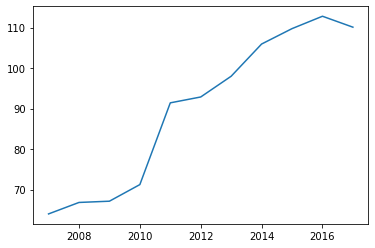

In [14]:
plt.plot(area_annual_act.loc['Newham'])

In [15]:
slopes.loc['Newham']

before    6.349143
after     3.839561
diff     -0.027882
Name: Newham, dtype: float64

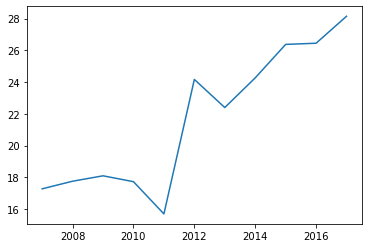

In [16]:
plt.plot(area_annual_act.loc['Greenwich'])

In [17]:
slopes.loc['Greenwich']

before    0.797143
after     0.975916
diff      0.008249
Name: Greenwich, dtype: float64

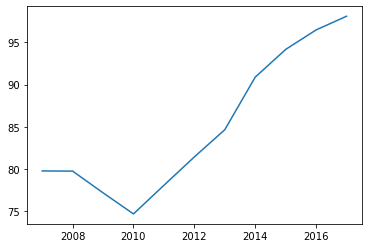

In [18]:
plt.plot(area_annual_act.loc['Brent'])

In [19]:
slopes.loc['Brent']

before    0.021714
after     3.486801
diff      0.040760
Name: Brent, dtype: float64

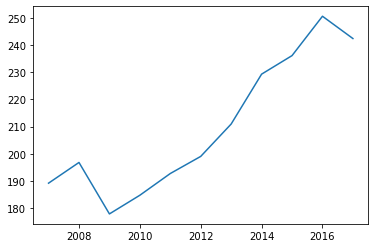

In [20]:
plt.plot(area_annual_act.loc['City of London'])

In [21]:
slopes.loc['City of London']

before    1.254571
after     9.787711
diff      0.040638
Name: City of London, dtype: float64

Load london borough shape data
==============================

In [22]:
map_df = gpd.read_file(LONDON_BOROUGH_SHAPES)
map_df = map_df.to_crs('epsg:3857')

In [23]:
map_df.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((-36811.020 6679699.611, -36801.601 6..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((-7126.807 6677851.759, -7132.828 667..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((1350.415 6674461.413, 1331.568 66744..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((-27224.557 6708199.030, -27237.660 6..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((-45845.001 6716316.317, -45850.623 6..."


In [24]:
locations = pd.DataFrame({
    'Name': ['Olympic Park'],
    'Latitude': [51.54615],
    'Longitude': [-0.01269]
})

In [25]:
geo_locs = gpd.GeoDataFrame(locations, geometry=gpd.points_from_xy(locations.Longitude, locations.Latitude), crs="EPSG:4326")

In [26]:
geo_locs = geo_locs.to_crs('epsg:3857')

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  This is separate from the ipykernel package so we can avoid doing imports until


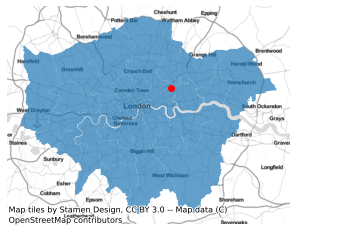

In [27]:
ax = map_df.plot(alpha=0.7)
geo_locs.plot(ax=ax, color='red', label="test", legend="bottomright")
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

Plot merged data
================

In [28]:
merged = map_df.set_index('NAME').join(area_annual_act)

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  This is separate from the ipykernel package so we can avoid doing imports until


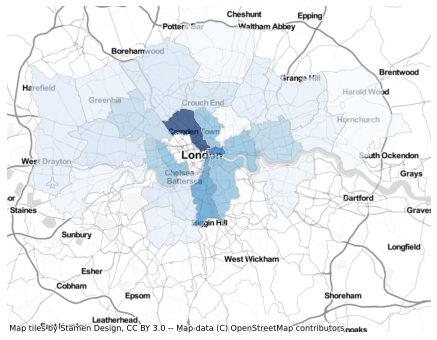

In [29]:
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column=2017, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.7)
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

In [30]:
merged_diffs = map_df.set_index('NAME').join(slopes)

In [31]:
merged_diffs['before'] = merged_diffs['before'] / area_annual_act.mean(axis=1)

In [32]:
merged_diffs['before']

NAME
Kingston upon Thames           NaN
Croydon                        NaN
Bromley                        NaN
Hounslow                  0.017707
Ealing                   -0.001643
Havering                  0.014120
Hillingdon                0.020143
Harrow                    0.001776
Brent                     0.000255
Barnet                    0.023008
Lambeth                   0.026565
Southwark                 0.024455
Lewisham                       NaN
Greenwich                 0.036783
Bexley                         NaN
Enfield                  -0.003778
Waltham Forest            0.015208
Redbridge                 0.032519
Sutton                         NaN
Richmond upon Thames           NaN
Merton                   -0.012756
Wandsworth               -0.002979
Hammersmith and Fulham    0.019740
Kensington and Chelsea    0.012360
Westminster                    NaN
Camden                    0.028429
Tower Hamlets             0.022986
Islington                 0.016309
Hackney        

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  after removing the cwd from sys.path.


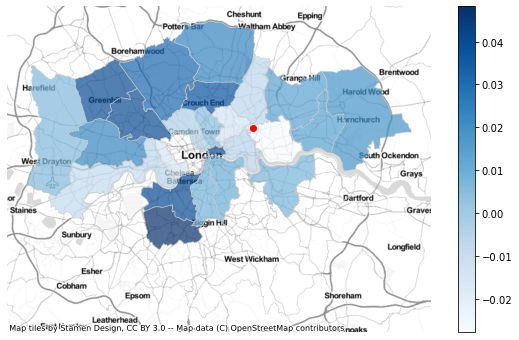

In [35]:
fig, ax = plt.subplots(1, figsize=(10, 6))
merged_diffs.plot(column='diff', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend='bottomright', alpha=0.7)
geo_locs.plot(ax=ax, color='red', label="test", legend=True)
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()
plt.savefig('test.png')

In [34]:
merged_alls = map_df.set_index('NAME').join(pd.DataFrame(all_slopes))

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  after removing the cwd from sys.path.


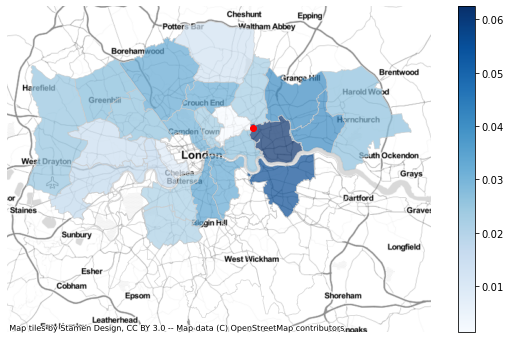

In [36]:
fig, ax = plt.subplots(1, figsize=(10, 6))
merged_alls.plot(column=0, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend='bottomright', alpha=0.7)
geo_locs.plot(ax=ax, color='red', label="test", legend=True)
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()
plt.savefig('test.png')

In [40]:
dists = pd.read_csv('region_distances.csv').set_index('NAME')

In [41]:
slopes.join(dists).corr()

,before,after,diff,Distance
before,1.000000,0.998431,-0.156415,-0.283145
after,0.998431,1.000000,-0.121845,-0.306394
diff,-0.156415,-0.121845,1.000000,-0.298121
Distance,-0.283145,-0.306394,-0.298121,1.000000


In [42]:
pd.DataFrame(all_slopes).join(dists).corr()

,0,Distance
0,1.000000,-0.281912
Distance,-0.281912,1.000000


In [43]:
profiles = pd.read_csv('london-borough-profiles.csv', encoding='ISO-8859-2')

In [44]:
profiles.set_index('Area_name').join(slopes).corr().loc['diff']

GLA_Population_Estimate_2017                          0.102937
Average_Age,_2017                                    -0.197867
Proportion_of_population_aged_0-15,_2015              0.234001
Proportion_of_population_of_working-age,_2015        -0.058748
Proportion_of_population_aged_65_and_over,_2015      -0.165712
New_migrant_(NINo)_rates,_(2015/16)                   0.211054
Employment_rate_(%)_(2015)                           -0.268983
%_of_employment_that_is_in_public_sector_(2014)       0.405367
Jobs_Density,_2015                                    0.081866
Number_of_active_businesses,_2015                    -0.212726
Two-year_business_survival_rates_(started_in_2013)   -0.403788
Number_of_cars,_(2011_Census)                        -0.040577
Number_of_cars_per_household,_(2011_Census)           0.020688
%_children_living_in_out-of-work_households_(2015)    0.008810
Life_satisfaction_score_2011-14_(out_of_10)          -0.265086
Worthwhileness_score_2011-14_(out_of_10)             -0

Regression
==========

In [60]:
all_things = slopes.join(dists).join(profiles.set_index('Area_name'))

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = all_things.select_dtypes(include=numerics)
newdf.dropna(inplace=True)

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [61]:
reg_diff = LinearRegression()

reg_diff.fit(newdf.drop(['before', 'after', 'diff'], axis=1), newdf['diff'])

LinearRegression()

In [62]:
reg_diff.coef_

array([ 4.66272168e-06,  7.38100573e-10, -4.00936008e-05, -2.77059287e-05,
       -7.88335416e-07,  2.03176371e-05,  1.06947603e-06,  2.14235947e-06,
        7.68471065e-06,  3.12433310e-07,  2.56687426e-09,  6.32214625e-06,
       -3.99609428e-09,  3.31323400e-04, -2.03597710e-06, -3.15576107e-04,
        5.93554844e-04, -1.80804219e-04, -3.08948347e-05,  1.67373088e-05])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text major ticklabel objects>)

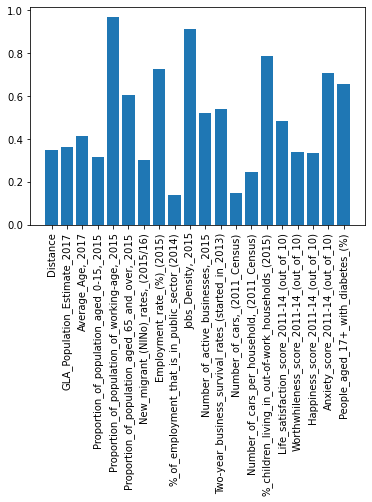

In [67]:
plt.bar(newdf.drop(['before', 'after', 'diff'], axis=1).columns, reg_diff.p[0])
plt.xticks(rotation=90)

In [63]:
y_preds = reg_diff.predict(newdf.drop(['before', 'after', 'diff'], axis=1))

In [64]:
sklearn.metrics.r2_score(newdf['diff'], y_preds)

0.7939614833186228

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text major ticklabel objects>)

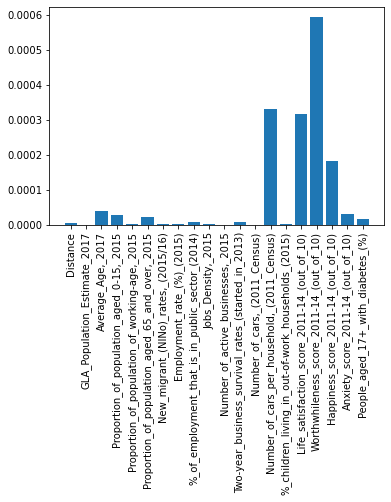

In [65]:
plt.bar(newdf.drop(['before', 'after', 'diff'], axis=1).columns, abs(reg_diff.coef_))
plt.xticks(rotation=90)

In [2]:
scipy.stats.linregress(x_test, newdf['diff'])

NameError: name 'x_test' is not defined